[I 2024-12-26 08:47:05,386] A new study created in memory with name: no-name-8317d318-d87f-4f82-9a1a-8acb73e9bb3a
[I 2024-12-26 08:47:12,713] Trial 0 finished with value: 4424.6566352731925 and parameters: {'learning_rate': 0.15043986115427688, 'max_depth': 4, 'subsample': 0.5486800304609736, 'colsample_bytree': 0.6537474106837158, 'gamma': 0.45858273442679787, 'min_child_weight': 10, 'reg_alpha': 7.796013052071612, 'reg_lambda': 8.59425157147028}. Best is trial 0 with value: 4424.6566352731925.
[I 2024-12-26 08:47:25,210] Trial 1 finished with value: 4151.120505010376 and parameters: {'learning_rate': 0.02259973473099445, 'max_depth': 8, 'subsample': 0.8396493971111415, 'colsample_bytree': 0.664792242021232, 'gamma': 1.9748344403547287, 'min_child_weight': 2, 'reg_alpha': 4.358242732036894, 'reg_lambda': 7.259156800008628}. Best is trial 1 with value: 4151.120505010376.
[I 2024-12-26 08:47:35,319] Trial 2 finished with value: 4142.087248749695 and parameters: {'learning_rate': 0.08982

Best Parameters: {'learning_rate': 0.05197553220137302, 'max_depth': 9, 'subsample': 0.927752800458483, 'colsample_bytree': 0.6190518351609318, 'gamma': 2.768889056775817, 'min_child_weight': 1, 'reg_alpha': 2.8984078720738786, 'reg_lambda': 6.6196946947101845}
Improved RMSE: 3791.9229949987116
Improved R² Score: 0.9726181030273438


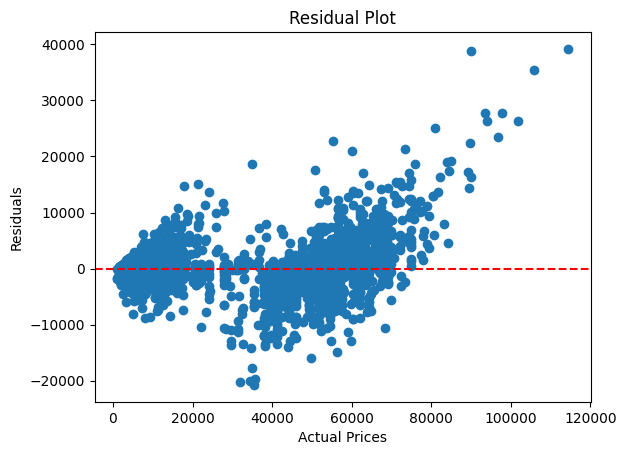

Test predictions saved to 'test_predictions.csv'


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, DMatrix, cv
import optuna
import matplotlib.pyplot as plt


# Data Loading
train_data = pd.read_csv('/content/train_data.csv')
test_data = pd.read_csv( '/content/test_data.csv')



# Feature Engineering Function
def preprocess_data(train, test):

    # Log Transformation of 'duration': The 'duration' feature is log-transformed to deal with skewness in the distribution.

    train['log_duration'] = np.log1p(train['duration'])
    test['log_duration'] = np.log1p(test['duration'])


    # Encoding 'stops': The categorical 'stops' feature (with values 'zero' and 'one') is numerically encoded.

    stops_mapping = {'zero': 0, 'one': 1}
    train['stops_encoded'] = train['stops'].map(stops_mapping)
    test['stops_encoded'] = test['stops'].map(stops_mapping)


    # Frequency Encoding for Categorical Variables: The 'airline', 'source_city', and 'destination_city' categorical features are encoded based on their frequency in the training data (i.e., the proportion of each category).
    for col in ['airline', 'source_city', 'destination_city']:
        freq_encoding = train[col].value_counts(normalize=True).to_dict()
        train[f'{col}_freq'] = train[col].map(freq_encoding)
        test[f'{col}_freq'] = test[col].map(freq_encoding)

    # One-Hot Encoding: The 'departure_time', 'arrival_time', and 'class' categorical features are one-hot encoded, converting them into binary features.

    categorical_columns = ['departure_time', 'arrival_time', 'class']
    train = pd.get_dummies(train, columns=categorical_columns, drop_first=True)
    test = pd.get_dummies(test, columns=categorical_columns, drop_first=True)

    # Dropping Unnecessary Columns: Several columns, including 'flight', 'duration', 'stops', 'airline', 'source_city', 'destination_city', and 'price' (target variable), are dropped from the features. Only relevant features remain.
    drop_columns = ['flight', 'duration', 'stops', 'airline', 'source_city', 'destination_city', 'price', 'id']
    train_features = train.drop(columns=drop_columns, errors='ignore')
    test_features = test.drop(columns=['flight', 'duration', 'stops', 'airline', 'source_city', 'destination_city', 'id'],
                               errors='ignore')

    # Align Test Data: To ensure consistency between the training and test data, the test dataset is aligned with the training dataset by ensuring the same columns are present in both, filling any missing columns with zeros.
    test_features = test_features.reindex(columns=train_features.columns, fill_value=0)

    # Target variable
    target = train['price']

    return train_features, target, test_features

# Preprocess the data
X_train, y_train, X_test = preprocess_data(train_data, test_data)

# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Prepare data for XGBoost
dtrain = DMatrix(X_train_split, label=y_train_split)

# Hyperparameter Tuning with Optuna
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10)
    }

    # Use XGBoost's native cross-validation
    cv_results = cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        nfold=5,
        metrics="rmse",
        early_stopping_rounds=20,
        seed=42
    )

    return cv_results['test-rmse-mean'].min()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("Best Parameters:", best_params)

# Train Final Model with Best Parameters
final_model = XGBRegressor(**best_params, n_estimators=500, random_state=42)
final_model.fit(X_train_split, y_train_split)

# Predict on Validation Set
val_pred = final_model.predict(X_val_split)

# Evaluate the Model
mse = mean_squared_error(y_val_split, val_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val_split, val_pred)
print(f"Improved RMSE: {rmse}")
print(f"Improved R² Score: {r2}")

# Residual Analysis
val_residuals = y_val_split - val_pred
plt.scatter(y_val_split, val_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Predict on Test Set
test_predictions = final_model.predict(X_test)

# Save Test Predictions
test_data['predicted_price'] = test_predictions
test_data[['id', 'predicted_price']].to_csv('test_predictions.csv', index=False)

print("Test predictions saved to 'test_predictions.csv'")


In [5]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00
